# Analysis of Return A data

This notebook analyzes data from the FBI's "Return A" data. Please see this repository's `README.md` file for more context.

# Import Python libraries

In [1]:
# Data analysis
import pandas as pd

# Charting
import matplotlib as mpl
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
%matplotlib inline

# Misc.
from utils import (
    percentify_axes,
    plot_rates,
    load_reta_metadata_2016,
    load_reta_annual_counts,
    save,
)

# Load agency metadata

Here, we load each agency's annual population and population "group", which we extracted from the raw Return A data for each agency and year.

Each agency receives an FBI-assigned group, based on the agency type and the population of its jurisdiction. The first four classifications, in bold, are those we term "larger city agencies" or "urban police departments".

- **1A = Cities 1,000,000 or over**
- **1B = Cities from 500,000 thru 999,999**
- **1C = Cities from 250,000 thru 499,999**
- **2 = Cities from 100,000 thru 249,000**
- 3 = Cities from 50,000 thru 99,000
- 4 = Cities from 25,000 thru 49,999
- 5 = Cities from 10,000 thru 24,999
- 6 = Cities from 2,500 thru 9,999
- 7 = Cities under 2,500
- 8A = Non-MSA counties 100,000 or over
- 8B = Non-MSA counties from 25,000 thru 99,999
- 8C = Non-MSA counties from 10,000 thru 24,999
- 8D = Non-MSA counties under 10,000
- 8E = Non-MSA State Police
- 9A = MSA counties 100,000 or over
- 9B = MSA counties from 25,000 thru 99,999
- 9C = MSA counties from 10,000 thru 24,999
- 9D = MSA counties under 10,000
- 9E = MSA State Police
- 0 = Possessions


In [2]:
agency_metadata_2016 = load_reta_metadata_2016()
agency_metadata_2016["pop"] = agency_metadata_2016[[ "pop1", "pop2", "pop3" ]].sum(axis = 1)
agency_metadata_2016.head()

,year,agency_ori_7,agency_name,ori_group,pop1,pop2,pop3,larger_city,pop
936209,2016,VI00103,ST. CROIX,0,0,0,0,False,0
921171,2016,ME00201,CARIBOU,6,7747,0,0,False,7747
921107,2016,LA05304,AMITE,6,4421,0,0,False,4421
921108,2016,LA05305,INDEPENDENCE,7,1820,0,0,False,1820
921109,2016,LA05306,ROSELAND,7,1219,0,0,False,1219


In [3]:
(
    agency_metadata_2016
    ["ori_group"]
    .value_counts()
    .sort_index()
)

0        6
1A      11
1B      24
1C      52
2      225
3      502
4      928
5     1992
6     4383
7     8039
8A       4
8B     300
8C     671
8D    2573
8E     114
9A     174
9B     492
9C     290
9D    2272
9E     139
Name: ori_group, dtype: int64

# Load annual counts

... limited to murder, gun assaults, and non-gun aggravated assaults since 1965.

In [4]:
annual_counts = load_reta_annual_counts()

annual_counts.head()

,agency_ori_7,year,offense,actual,cleared,ori_group_report,larger_city_report,ori_group_2016,larger_city_2016
8,AK00101,1965,assault_gun,28,19,4,False,1C,True
9,AK00101,1965,murder,7,6,4,False,1C,True
10,AK00101,1966,assault_gun,22,17,3,False,1C,True
11,AK00101,1966,murder,18,16,3,False,1C,True
12,AK00101,1967,assault_gun,24,21,3,False,1C,True


In [5]:
annual_counts["offense"].value_counts().sort_index()

assault_all       916510
assault_gun       916510
assault_nongun    916510
murder            916510
Name: offense, dtype: int64

# Examine zero-counts

There are many instances in which an agency will report offenses, but no clearances, in its Return A data. Here, we examine that issue.

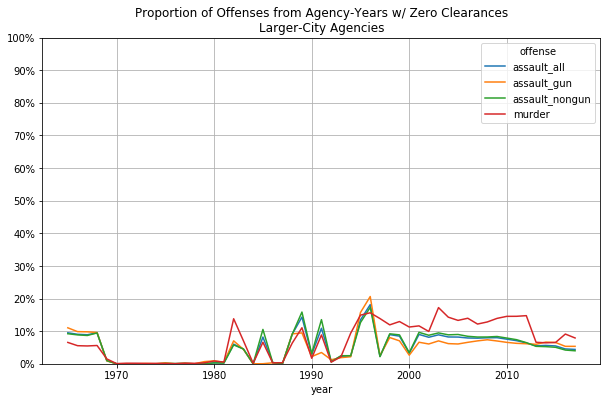

In [6]:
ax = (
    annual_counts
    .loc[lambda df: df["larger_city_2016"] == True]
    .assign(
        zero_clearances = lambda df: df["cleared"] == 0
    )
    .groupby([
        "year",
        "offense",
        "zero_clearances",
    ])
    ["actual"]
    .sum()
    .unstack()
    .pipe(lambda df: df[True] / df.sum(axis = 1))
    .unstack()
    .plot(
        figsize = (10, 6),
        title = (
            "Proportion of Offenses from Agency-Years w/ Zero Clearances\n"
            "Larger-City Agencies"
        ),
    )
)
percentify_axes(ax)
ax.grid()
pass

A large proportion of those agency-years are accounted for by the NYPD and Chicago Police Department. Here are the agencies with the largest number of murders reported during zero-clearance-reported years, since 1980:

In [7]:
(
    annual_counts
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["year"] >= 1980]
    .loc[lambda df: df["cleared"] == 0]
    .groupby([
        "agency_ori_7",
        "offense"
    ])
    ["actual"]
    .sum()
    .unstack()
    .fillna(0)
    .astype(int)
    .sort_values("murder", ascending = False)
    .head(10)
)

offense,assault_all,assault_gun,assault_nongun,murder
agency_ori_7,,,,
ILCPD00,242885,46542,196343,18447
NY03030,0,0,0,5262
AL00102,15149,3890,11259,1622
TXHPD00,3461,1466,1995,678
MI82349,12356,4908,7448,475
AL00201,8102,803,7299,468
MN02711,10805,3115,7690,420
KS08703,16183,4095,12088,413
FL01602,83330,30124,53206,408


# Examine reporting consistency

These sorts of agency reports can throw off metrics; almost certainly those agencies made clearances, but simply did not report the number to Return A. For our analyses, we generally want to focus on agencies that consistently reported clearances to the FBI.

In [8]:
# Note: Reporting clearances without reporting offenses, on the other hand,
# does not appear to be a substantial issue. Of larger-city agencies, 
# none have ever reported 8+ clearance but no offenses
# (for the offense categories we're examining)
assert (
    annual_counts
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["actual"] == 0]
    .loc[lambda df: df["cleared"] >= 8]
    .pipe(len)
) == 0

In [9]:
agency_years_with_clearances = (
    annual_counts
    .set_index([
        "agency_ori_7",
        "larger_city_2016",
        "year",
        "offense"
    ])
    .pipe(lambda df: df["cleared"] > 0)
    .to_frame("has_clearances")
    .reset_index()
)

agency_years_with_clearances.head()

,agency_ori_7,larger_city_2016,year,offense,has_clearances
0,AK00101,True,1965,assault_gun,True
1,AK00101,True,1965,murder,True
2,AK00101,True,1966,assault_gun,True
3,AK00101,True,1966,murder,True
4,AK00101,True,1967,assault_gun,True


In [10]:
def calculate_consistency(offense, since_year, num_years):
    return (
        agency_years_with_clearances
        .loc[lambda df: df["offense"] == offense]
        .loc[lambda df: df["year"] >= since_year]
        .groupby([
            "agency_ori_7",
        ])
        [[ "has_clearances" ]]
        .sum()
        .reset_index()
        .rename(columns = {
            "has_clearances": "nonzero_years",
        })
        .assign(
            offense = offense,
            consistent = lambda df: df["nonzero_years"] >= num_years
        )
        .merge(
            agency_metadata_2016
            [[
                "agency_ori_7",
                "ori_group",
                "larger_city",
            ]],
            how = "left",
            validate = "1:1"
        )
    )

Here, we identify agencies that have reported at least one clearance for at least 34 of the 38 years between 1980 and 2017. This timeframe will be the main one we use in the analysis, but we also calculate a similar consistency metric for 1965–2017 (with threshold being 48 of 53 years) for comparison.

#### Murder

In [11]:
reporting_consistency_1980_murder = (
    calculate_consistency("murder", 1980, 34)
    .pipe(save, "../../outputs/reta-reporting-consistency-1980-murder.csv")
)

reporting_consistency_1980_murder.head()

,agency_ori_7,nonzero_years,offense,consistent,ori_group,larger_city
0,AK00101,38.0,murder,True,1C,True
1,AK00102,29.0,murder,False,4,False
2,AK00103,13.0,murder,False,4,False
3,AK00104,11.0,murder,False,6,False
4,AK00105,5.0,murder,False,6,False


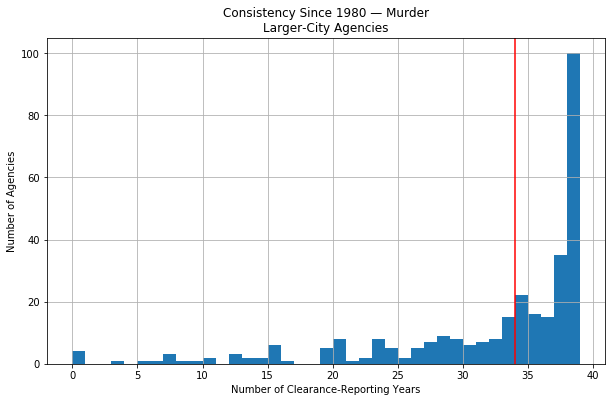

In [12]:
ax = (
    reporting_consistency_1980_murder
    .loc[lambda df: df["larger_city"] == True]
    ["nonzero_years"]
    .hist(
        bins = range(0, 40),
        figsize = (10, 6),
    )
)

ax.set_title(
    "Consistency Since 1980 — Murder\n"
    "Larger-City Agencies"
)

ax.set_xlabel("Number of Clearance-Reporting Years")
ax.set_ylabel("Number of Agencies")

ax.axvline(34, color = "red")
pass

In [13]:
(
    reporting_consistency_1980_murder
    .groupby([
        "larger_city",
    ])
    .pipe(lambda grp: pd.DataFrame({
        "total_agencies": grp.size(),
        "consistent_sum": grp["consistent"].sum(),
        "consistent_mean": grp["consistent"].mean(),
    }))
    .round(2)
)

,total_agencies,consistent_sum,consistent_mean
larger_city,,,
False,22722,253.0,0.01
True,312,188.0,0.60


#### Gun assaults

In [14]:
reporting_consistency_1980_gun_assault = (
    calculate_consistency("assault_gun", 1980, 34)
    .pipe(save, "../../outputs/reta-reporting-consistency-1980-gun-assault.csv")
)    
reporting_consistency_1980_gun_assault.head()

,agency_ori_7,nonzero_years,offense,consistent,ori_group,larger_city
0,AK00101,38.0,assault_gun,True,1C,True
1,AK00102,38.0,assault_gun,True,4,False
2,AK00103,28.0,assault_gun,False,4,False
3,AK00104,28.0,assault_gun,False,6,False
4,AK00105,29.0,assault_gun,False,6,False


In [15]:
(
    reporting_consistency_1980_gun_assault
    .groupby([
        "larger_city",
    ])
    .pipe(lambda grp: pd.DataFrame({
        "total_agencies": grp.size(),
        "consistent_sum": grp["consistent"].sum(),
        "consistent_mean": grp["consistent"].mean(),
    }))
    .round(2)
)

,total_agencies,consistent_sum,consistent_mean
larger_city,,,
False,22722,1148.0,0.05
True,312,234.0,0.75


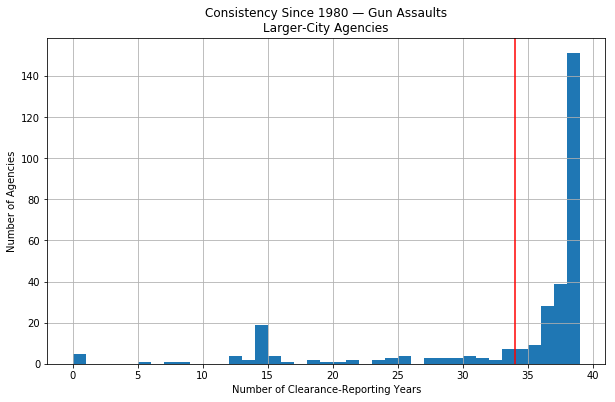

In [16]:
ax = (
    reporting_consistency_1980_gun_assault
    .loc[lambda df: df["larger_city"] == True]
    ["nonzero_years"]
    .hist(
        bins = range(0, 40),
        figsize = (10, 6),
    )
)

ax.set_title(
    "Consistency Since 1980 — Gun Assaults\n"
    "Larger-City Agencies"
)

ax.set_xlabel("Number of Clearance-Reporting Years")
ax.set_ylabel("Number of Agencies")

ax.axvline(34, color = "red")
pass

In [17]:
reporting_consistency_1980_nongun_assault = calculate_consistency("assault_nongun", 1980, 34)

reporting_consistency_1965_murder = calculate_consistency("murder", 1965, 48)
reporting_consistency_1965_gun_assault = calculate_consistency("assault_gun", 1965, 48)
reporting_consistency_1965_nongun_assault = calculate_consistency("assault_nongun", 1965, 48)

In [18]:
(
    pd.concat([
        reporting_consistency_1980_gun_assault,
        reporting_consistency_1980_murder,
    ])
    .loc[lambda df: df["larger_city"] == True]
    .merge(
        pd.concat([
            reporting_consistency_1965_gun_assault,
            reporting_consistency_1965_murder
        ])
        .loc[lambda df: df["larger_city"] == True],
        how = "left",
        on = [ "agency_ori_7", "offense" ],
        suffixes = [ "_1980", "_1965" ]
    )
    .groupby([
        "offense",
        "consistent_1980",
        "consistent_1965"
    ])
    .size()
    .unstack()
)

consistent_1965              False  True 
offense     consistent_1980              
assault_gun False               74      4
            True                28    206
murder      False              120      4
            True                17    171

# Add reporting-consistency labels to annual data

In [19]:
annual_counts_annotated = (
    annual_counts
    .loc[lambda df: df["offense"] != "assault_all"]
    .merge(
        (
            pd.concat([
                reporting_consistency_1980_murder,
                reporting_consistency_1980_gun_assault,
                reporting_consistency_1980_nongun_assault,
            ])
            [["agency_ori_7", "offense", "consistent"]]
        ),
        how = "left",
        on = [ "agency_ori_7", "offense" ]
    )
    .merge(
        (
            pd.concat([
                reporting_consistency_1965_murder,
                reporting_consistency_1965_gun_assault,
                reporting_consistency_1965_nongun_assault
            ])
            [["agency_ori_7", "offense", "consistent"]]
        ),
        how = "left",
        on = [ "agency_ori_7", "offense" ],
        suffixes = [ "_1965", "_1980" ]
    )
)

annual_counts_annotated.head()

,agency_ori_7,year,offense,actual,cleared,ori_group_report,larger_city_report,ori_group_2016,larger_city_2016,consistent_1965,consistent_1980
0,AK00101,1965,assault_gun,28,19,4,False,1C,True,True,True
1,AK00101,1965,murder,7,6,4,False,1C,True,True,True
2,AK00101,1966,assault_gun,22,17,3,False,1C,True,True,True
3,AK00101,1966,murder,18,16,3,False,1C,True,True,True
4,AK00101,1967,assault_gun,24,21,3,False,1C,True,True,True


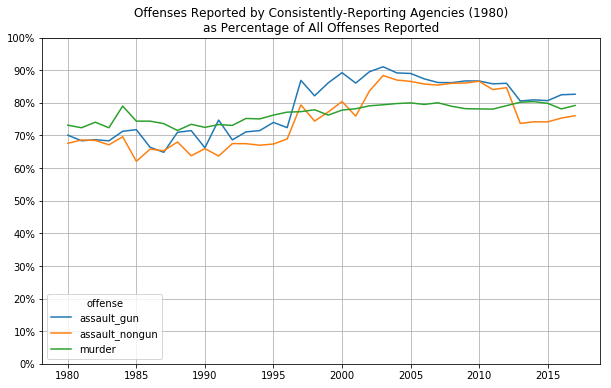

In [20]:
ax = (
    annual_counts_annotated
    .loc[lambda df: df["year"] >= 1980]
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([
        "year",
        "offense",
        "consistent_1980",
    ])
    ["actual"]
    .sum()
    .unstack()
    .pipe(lambda df: df[True] / df.sum(axis = 1))
    .unstack()
    .plot(
        figsize = (10, 6),
        title = (
            "Offenses Reported by Consistently-Reporting Agencies (1980)\n"
            "as Percentage of All Offenses Reported"
        )
    )
)
percentify_axes(ax)
ax.grid()
ax.set_xlabel(None)
pass

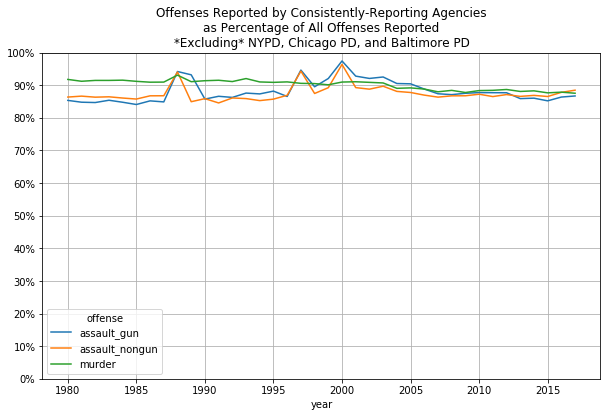

In [21]:
ax = (
    annual_counts_annotated
    .loc[lambda df: df["year"] >= 1980]
    .loc[lambda df: ~df["agency_ori_7"].isin([
        "NY03030", 
        "ILCPD00", 
        "MDBPD00", 
    ])]
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([
        "year",
        "offense",
        "consistent_1965",
    ])
    ["actual"]
    .sum()
    .unstack()
    .pipe(lambda df: df[True] / df.sum(axis = 1))
    .unstack()
    .plot(
        figsize = (10, 6),
        title = (
            "Offenses Reported by Consistently-Reporting Agencies\n"
            "as Percentage of All Offenses Reported\n"
            "*Excluding* NYPD, Chicago PD, and Baltimore PD"
        )
    )
)
percentify_axes(ax)
ax.grid()
pass

The highest-murder cities today that have not reported consistently:

In [22]:
(
    annual_counts_annotated
    .loc[lambda df: df["year"] == 2017]
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["consistent_1980"] == False]
    .loc[lambda df: df["offense"] == "murder"]
    .sort_values("actual", ascending = False)
    .loc[lambda df: df["actual"] >= 50]
)

,agency_ori_7,year,offense,actual,cleared,ori_group_report,larger_city_report,ori_group_2016,larger_city_2016,consistent_1965,consistent_1980
477319,ILCPD00,2017,murder,653,0,1A,True,1A,True,False,False
1132697,NY03030,2017,murder,292,268,1A,True,1A,True,False,False
576311,KY05680,2017,murder,109,54,1B,True,1B,True,False,False
3917,AL00102,2017,murder,59,15,2,True,2,True,False,False
6875,AL00201,2017,murder,50,42,2,True,2,True,False,False


The highest-gun-assault cities today that have not reported consistently:

In [23]:
(
    annual_counts_annotated
    .loc[lambda df: df["year"] == 2017]
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["consistent_1980"] == False]
    .loc[lambda df: df["offense"] == "assault_gun"]
    .sort_values("actual", ascending = False)
    .loc[lambda df: df["actual"] >= 1000]
)

,agency_ori_7,year,offense,actual,cleared,ori_group_report,larger_city_report,ori_group_2016,larger_city_2016,consistent_1965,consistent_1980
1132696,NY03030,2017,assault_gun,2424,1297,1A,True,1A,True,False,False
223224,FL01602,2017,assault_gun,2039,0,1B,True,1B,True,False,False
685606,MDBPD00,2017,assault_gun,1428,196,1B,True,1B,True,False,False
576310,KY05680,2017,assault_gun,1412,439,1B,True,1B,True,False,False
543180,KS08703,2017,assault_gun,1227,563,1C,True,1C,True,False,False
475350,IL10104,2017,assault_gun,1036,141,2,True,2,True,False,False


The aggregate 2017 clearance rates are higher at consistently-reporting agencies, but those agencies account for relatively few of the overall offenses — especiall for gun assaults and murders:

In [24]:
# Overall larger-city rates, regardless of consistency
(
    annual_counts_annotated
    .loc[lambda df: df["cleared"] > 0]
    .loc[lambda df: df["year"] == 2017]
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([
        "offense",
    ])
    [[ "actual", "cleared" ]]
    .sum()
    .assign(clearance_rate = lambda df: df["cleared"] / df["actual"])
)

,actual,cleared,clearance_rate
offense,,,
assault_gun,105286,32024,0.304162
assault_nongun,236066,127803,0.541387
murder,8338,4928,0.591029


In [25]:
# ... and disaggregated by consistency:
(
    annual_counts_annotated
    .loc[lambda df: df["cleared"] > 0]
    .loc[lambda df: df["year"] == 2017]
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([
        "offense",
        "consistent_1980"
    ])
    [[ "actual", "cleared" ]]
    .sum()
    .assign(clearance_rate = lambda df: df["cleared"] / df["actual"])
)

actual  cleared  clearance_rate
offense        consistent_1980                                 
assault_gun    False             13352     4664        0.349311
               True              91934    27360        0.297605
assault_nongun False             49060    31504        0.642152
               True             187006    96299        0.514951
murder         False              1171      823        0.702818
               True               7167     4105        0.572764

# Calculate and plot overall clearance rates

In [26]:
def calculate_clearance_rate(df):
    if isinstance(df, pd.DataFrame):
        return df["cleared"].sum() / df["actual"].sum()
    else:
        return df["cleared"] / df["actual"]

In [27]:
def plot_clearance_rate(df, to_csv = None, **kwargs):  
    grp = (
        df
        .loc[lambda df: df["cleared"] > 0]
        .groupby([ "year", "offense" ])
    )
    
    rates = (
        grp
        .apply(calculate_clearance_rate)
        .unstack()
    )
    
    if to_csv is not None:
        (
            rates
            .reset_index()
            .merge(
                grp["agency_ori_7"].nunique().unstack().reset_index(),
                on = [ "year" ],
                how = "left",
                suffixes = [ "_rate", "_agencies" ]
            )
            .to_csv(
                to_csv,
                index = False
            )
        )
        
    ax = plot_rates(rates, **kwargs)
    
    min_ind = min(rates.index)
    max_ind = max(rates.index)

    texts = []
    for year, row in rates.loc[[min_ind, max_ind]].iterrows():
        for col in rates.columns:
            nudge = -1 if year == min_ind else 1

            t = ax.text(
                year + nudge,
                row[col],
                "{:.0f}%".format(row[col] * 100)
            )

            texts.append(t)
        
    adjust_text(
        texts, 
        autoalign = 'y', 
        ax = ax,
        only_move = { 'points':'y', 'text':'y' },
        force_text = 0.1,
        force_points = 0,
        expand_text = (1, 1),
    )
    
    ax.set_ylabel("Clearance Rate")
    ax.legend(title = "Offense")

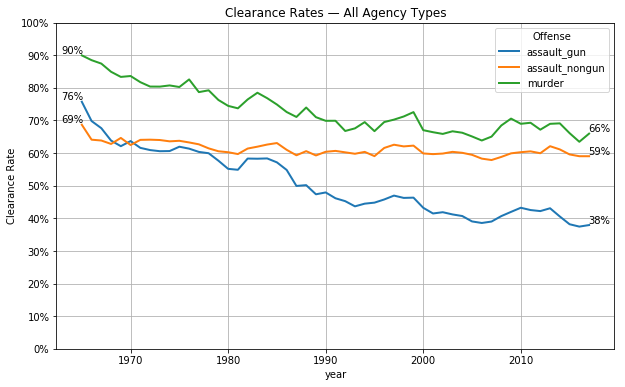

In [28]:
(
    annual_counts_annotated
    .pipe(
        plot_clearance_rate,
        title = "Clearance Rates — All Agency Types",
        to_csv = "../../outputs/reta-clearance-rates-all-agencies.csv"
    )
)

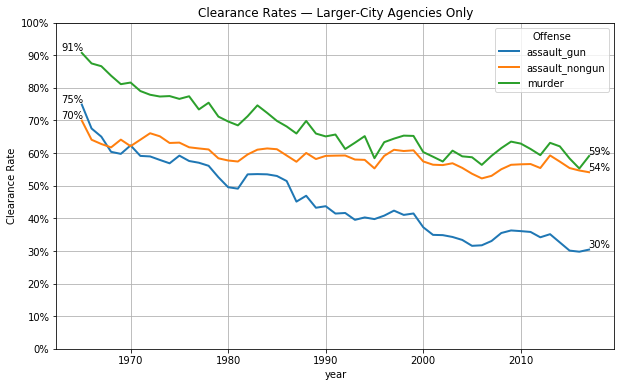

In [29]:
(
    annual_counts_annotated
    .loc[lambda df: df["larger_city_2016"] == True]
    .pipe(
        plot_clearance_rate,
        title = "Clearance Rates — Larger-City Agencies Only",
        to_csv = "../../outputs/reta-clearance-rates-larger-city-agencies.csv"
    )
)

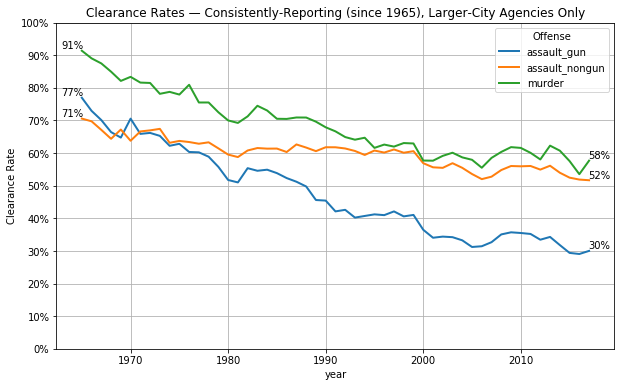

In [30]:
(
    annual_counts_annotated
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["consistent_1965"] == True]
    .pipe(
        plot_clearance_rate,
        title = "Clearance Rates — Consistently-Reporting (since 1965), Larger-City Agencies Only",        
        to_csv = "../../outputs/reta-clearance-rates-larger-city-consistent-1965.csv"
    )
)

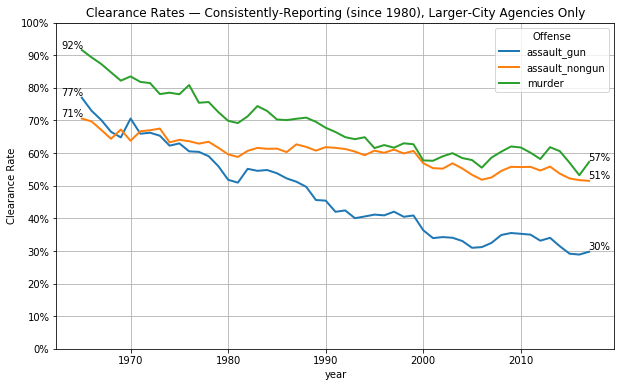

In [31]:
(
    annual_counts_annotated
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["consistent_1980"] == True]
    .pipe(
        plot_clearance_rate,
        title = "Clearance Rates — Consistently-Reporting (since 1980), Larger-City Agencies Only",        
        to_csv = "../../outputs/reta-clearance-rates-larger-city-consistent-1980.csv"
    )
)

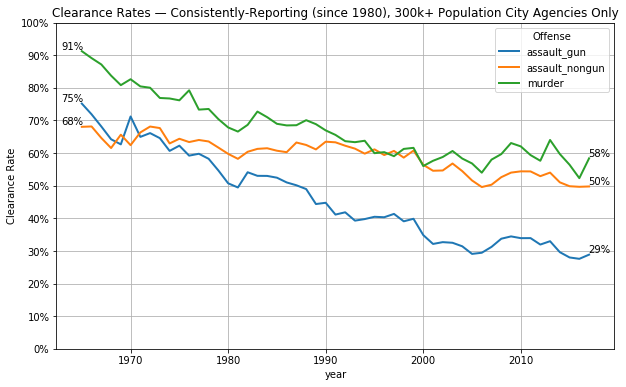

In [32]:
(
    annual_counts_annotated
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["consistent_1980"] == True]
    .loc[lambda df: df["agency_ori_7"].isin(
        agency_metadata_2016
        .loc[lambda df: df["pop"] >= 300000]
        ["agency_ori_7"]
    )]
    .pipe(
        plot_clearance_rate,
        title = "Clearance Rates — Consistently-Reporting (since 1980), 300k+ Population City Agencies Only",        
    )
)

For the sake of comparing gun and non-gun assault clearance rates since the 1980s, here we select only larger-city agencies that have reported clearances for both types of assaults consistently since 1980:

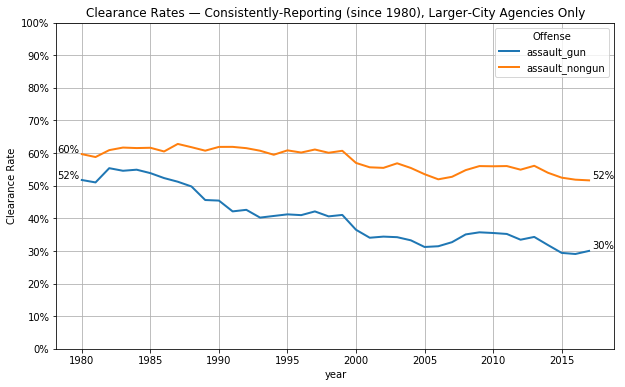

In [33]:
(
    annual_counts_annotated
    .loc[lambda df: df["year"] >= 1980]
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["agency_ori_7"].isin(
        reporting_consistency_1980_gun_assault
        .loc[lambda df: df["consistent"] == True]
        ["agency_ori_7"]
    )]
    .loc[lambda df: df["agency_ori_7"].isin(
        reporting_consistency_1980_nongun_assault
        .loc[lambda df: df["consistent"] == True]
        ["agency_ori_7"]
    )]
    .loc[lambda df: df["offense"].isin([
        "assault_gun",
        "assault_nongun"
    ])]
    .pipe(
        plot_clearance_rate,
        title = "Clearance Rates — Consistently-Reporting (since 1980), Larger-City Agencies Only",        
        to_csv = "../../outputs/reta-clearance-rates-main-assault-comparison.csv"
    )
)

# Create decade charts w/ interquartile ranges

In [34]:
interquartiles = (
    annual_counts_annotated
    .loc[lambda df: df["cleared"] > 0]
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["consistent_1965"] == True]
    .assign(
        decade = lambda df: 10 * (df["year"] // 10)
    )
    .groupby([
        "offense",
        "decade",
        "agency_ori_7"
    ])
    .apply(calculate_clearance_rate)
    .to_frame("clearance_rate")
    .reset_index()
    .groupby([
        "decade",
        "offense",
    ])
    ["clearance_rate"]
    .quantile([ 0.25, 0.75 ])
    .unstack(level = -2)
    .unstack()
)

interquartiles

offense assault_gun           assault_nongun              murder          
               0.25      0.75           0.25      0.75      0.25      0.75
decade                                                                    
1960       0.625000  0.833333       0.574468  0.798421  0.842819  0.971218
1970       0.544910  0.729837       0.534788  0.719803  0.768230  0.899580
1980       0.487048  0.670091       0.526102  0.717184  0.706136  0.866655
1990       0.382610  0.573018       0.515480  0.707806  0.597852  0.817015
2000       0.329004  0.502552       0.510566  0.676597  0.544226  0.784707
2010       0.307124  0.526136       0.505976  0.694974  0.552404  0.813741

In [35]:
decade_rates = (    
    annual_counts_annotated
    .loc[lambda df: df["cleared"] > 0]
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["consistent_1965"] == True]
    .assign(
        decade = lambda df: 10 * (df["year"] // 10)
    )
    .groupby([
        "offense",
        "decade",
    ])
    .apply(calculate_clearance_rate)
    .unstack(level = -2)
)

decade_rates

offense,assault_gun,assault_nongun,murder
decade,,,
1960,0.687520,0.676329,0.863135
1970,0.623392,0.640691,0.784015
1980,0.516021,0.609610,0.709850
1990,0.417242,0.607925,0.642748
2000,0.337748,0.550141,0.586987
2010,0.320428,0.541052,0.587513


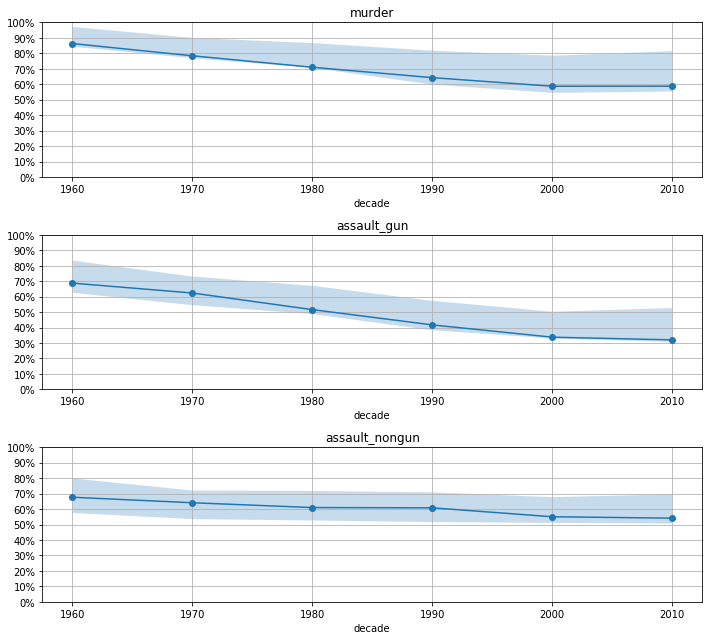

In [36]:
fig, axs = plt.subplots(figsize = (10, 3 * 3), nrows = 3)

for i, offense in enumerate([ "murder", "assault_gun", "assault_nongun" ]):
    ax = axs[i]
    (
        interquartiles
        [offense]
        .pipe(lambda df: ax.fill_between(
            df.index,
            df[0.25],
            df[0.75],
            alpha = 0.25
        ))
    )

    (
        decade_rates
        [offense]
        .plot(
            ax = ax,
            marker = "o",
            title = offense
        )
    )
    
    percentify_axes(ax)
    ax.grid()
plt.tight_layout()
pass

# Inspect clearance-rate distributions by decade

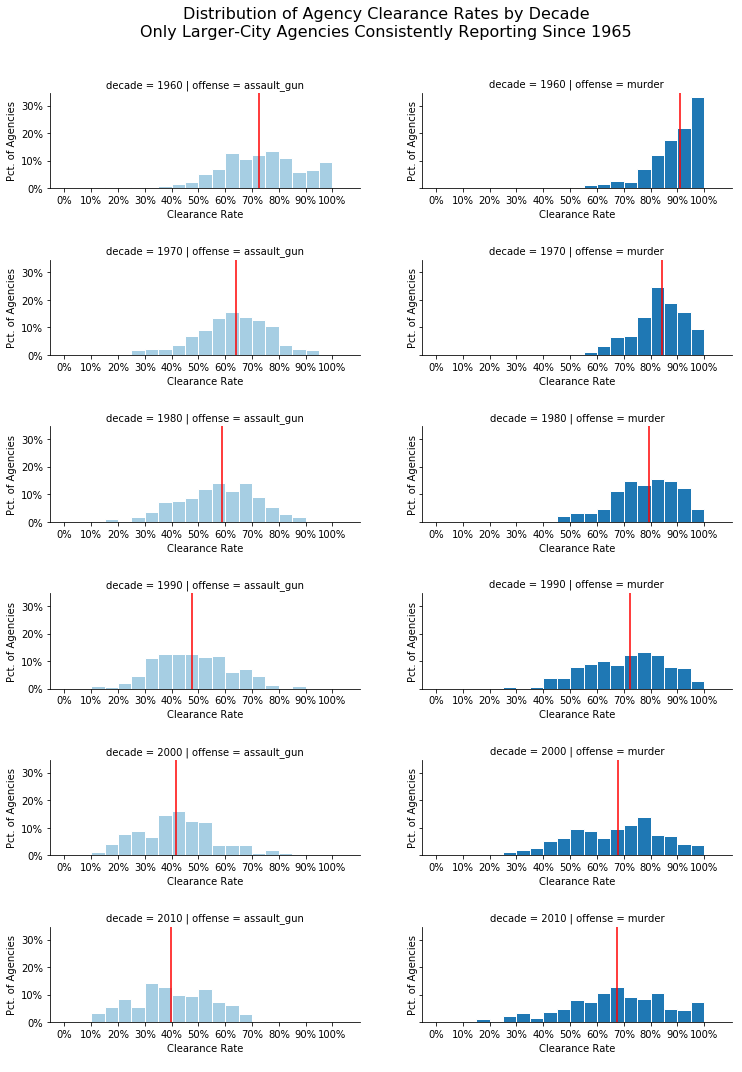

In [37]:
PCTS_BY_FIVE = pd.np.arange(0, 1.10, 0.05)

g = (
    (
        annual_counts_annotated
        .loc[lambda df: df["cleared"] > 0]
        .loc[lambda df: df["consistent_1965"] == True]
        .loc[lambda df: df["larger_city_2016"] == True]
        .loc[lambda df: df["offense"].isin([ "murder", "assault_gun" ])]
    )
    .assign(decade = lambda x: (x["year"] // 10) * 10)
    .groupby([ "decade", "offense", "agency_ori_7" ])
    .apply(calculate_clearance_rate)
    .clip(0, 0.999)
    .to_frame("clearance_rate")
    .reset_index()
    .pipe(lambda df: sns.FacetGrid(
        df,
        row = "decade",
        col = "offense",
        hue = "offense",
        sharey = True,
        sharex = False,
        height = 2.5,
        aspect = 2,
        palette = "Paired"
    ))
    .map(
        mpl.pyplot.hist,
        "clearance_rate",
        density = True,
        bins = PCTS_BY_FIVE,
        edgecolor = "white"
    )
    .map(
        lambda x, **kwargs: mpl.pyplot.axvline(
            x.quantile(0.5),
            **kwargs
        ),
        "clearance_rate",
        color = "red"
    )
)

g.fig.subplots_adjust(wspace=0.2, hspace=0.75)
for ax in g.axes.flatten():
    ax.set_xticks(PCTS_BY_FIVE[::2])
    ax.set_xticklabels([ "{:.0f}%".format(x * 100) for x in ax.get_xticks() ])
    ax.set_yticklabels([ "{:.0f}%".format(100 * y * 0.05) for y in ax.get_yticks() ])
    ax.set_ylabel("Pct. of Agencies")
    ax.set_xlabel("Clearance Rate\n")

    g.fig.suptitle((
    "Distribution of Agency Clearance Rates by Decade\n"
    "Only Larger-City Agencies Consistently Reporting Since 1965"
), size = 16)
    
g.fig.subplots_adjust(top=0.9)
g.fig.set_facecolor("white")
pass

Standard deviations for each decade:

In [38]:
(    
    (
        annual_counts_annotated
        .loc[lambda df: df["cleared"] > 0]
        .loc[lambda df: df["consistent_1965"] == True]
        .loc[lambda df: df["larger_city_2016"] == True]
        .loc[lambda df: df["offense"].isin([ "murder", "assault_gun" ])]
    )
    .assign(decade = lambda x: (x["year"] // 10) * 10)
    .groupby([ "decade", "offense", "agency_ori_7" ])
    .apply(calculate_clearance_rate)
    .to_frame("clearance_rate")
    .groupby([
        "decade",
        "offense"
    ])
    .std()
    .unstack()
)

clearance_rate          
offense    assault_gun    murder
decade                          
1960          0.162273  0.104796
1970          0.139825  0.096605
1980          0.138783  0.120527
1990          0.138441  0.154626
2000          0.146983  0.184002
2010          0.153015  0.225482

### Compare offense counts to clearance rates

Agencies with fewer than 50 murders in 2017 accounted for only approximately 35% of murders that year reported by agencies with 1+ clearance.

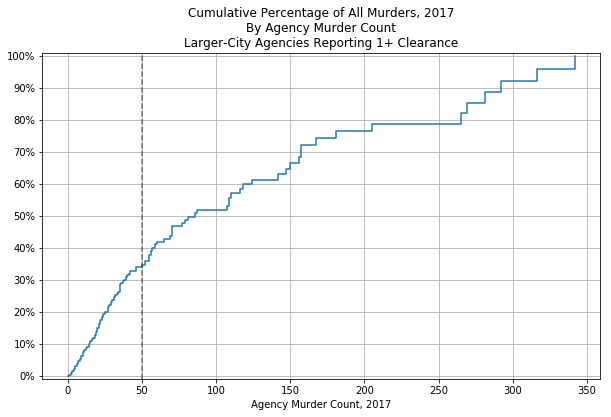

In [39]:
ax = (    
    annual_counts_annotated
    .loc[lambda df: df["cleared"] > 0]
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["offense"] == "murder"]
    .loc[lambda df: df["year"] == 2017]
    .sort_values("actual")
    .groupby("actual")
    [["actual"]]
    .sum()
    .assign(
        cumul_prop = lambda df: df["actual"].cumsum() / df["actual"].sum()
    )
    ["cumul_prop"]
    .plot(
        figsize = (10, 6),
        title = (
            "Cumulative Percentage of All Murders, 2017\n"
            "By Agency Murder Count\n"
            "Larger-City Agencies Reporting 1+ Clearance"
        ),
        drawstyle = "steps-post"
    )
)

percentify_axes(ax)
ax.set_ylim((-0.01, 1.01))
ax.set_xlabel("Agency Murder Count, 2017")
ax.axvline(50, color = "black", linestyle = "dashed", alpha = 0.5)
ax.grid()
pass

In general, as you include agencies with more and more murders, the aggregate clearance rate gradually decreases:

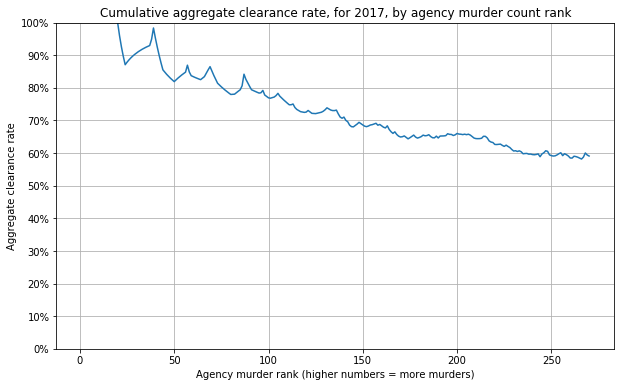

In [40]:
fig, ax = plt.subplots(figsize = (10, 3 * 3))

(
    annual_counts_annotated
    .loc[lambda df: df["cleared"] > 0]
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["year"] == 2017]
    .groupby([
        "offense",
        "agency_ori_7",
    ])
    .pipe(lambda grp: pd.DataFrame({
        "actual": grp["actual"].sum(),
        "cleared": grp["cleared"].sum(),
    }))
    .reset_index()
    .loc[lambda df: df["offense"] == "murder"]
    .sort_values(["actual", "cleared"])
    .set_index(["offense", "agency_ori_7"])
    .cumsum()
    .assign(
        clearance_rate = lambda df: df["cleared"] / df["actual"]
    )
    .reset_index()
    ["clearance_rate"]
    .plot(
        figsize = (10, 6),
        title = "Cumulative aggregate clearance rate, for 2017, by agency murder count rank",
    )
)
percentify_axes(ax)
ax.grid()
ax.set_xlabel("Agency murder rank (higher numbers = more murders)")
ax.set_ylabel("Aggregate clearance rate")
pass

Similarly for gun assaults:

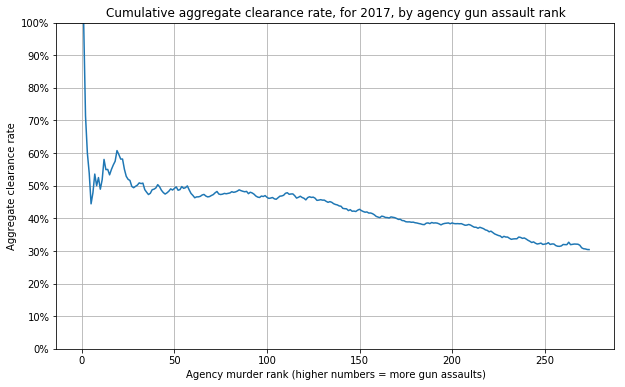

In [41]:
fig, ax = plt.subplots(figsize = (10, 3 * 3))

(
    annual_counts_annotated
    .loc[lambda df: df["cleared"] > 0]
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["year"] == 2017]
    .groupby([
        "offense",
        "agency_ori_7",
    ])
    .pipe(lambda grp: pd.DataFrame({
        "actual": grp["actual"].sum(),
        "cleared": grp["cleared"].sum(),
    }))
    .reset_index()
    .loc[lambda df: df["offense"] == "assault_gun"]
    .sort_values(["actual", "cleared"])
    .set_index(["offense", "agency_ori_7"])
    .cumsum()
    .assign(
        clearance_rate = lambda df: df["cleared"] / df["actual"]
    )
    .reset_index()
    ["clearance_rate"]
    .plot(
        figsize = (10, 6),
        title = "Cumulative aggregate clearance rate, for 2017, by agency gun assault rank",
    )
)
percentify_axes(ax)
ax.grid()
ax.set_xlabel("Agency murder rank (higher numbers = more gun assaults)")
ax.set_ylabel("Aggregate clearance rate")
pass

# Disaggregate clearance rates by agency type/size

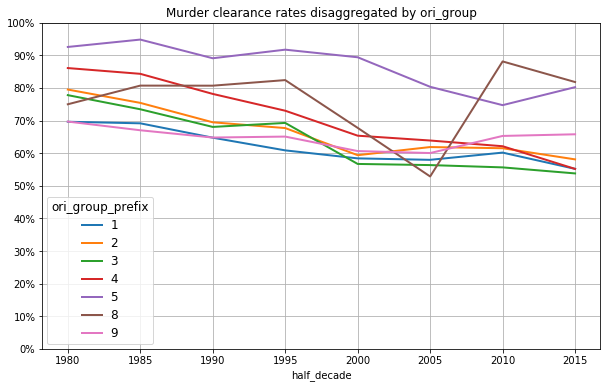

In [42]:
(
    (
        annual_counts_annotated
        .loc[lambda df: df["cleared"] > 0]
        .loc[lambda df: df["consistent_1980"] == True]
        .loc[lambda df: df["year"] >= 1980]
        .loc[lambda df: df["offense"] == "murder"]
    )
    .assign(
        half_decade = lambda df: (df["year"] // 5) * 5,
        ori_group_prefix = lambda df: df["ori_group_2016"].str.slice(0, 1)
    )
    .groupby([ "half_decade", "ori_group_prefix" ])
    .apply(calculate_clearance_rate)
    .unstack()
    .pipe(
        plot_rates,
        title = "Murder clearance rates disaggregated by ori_group"
    )
)
pass

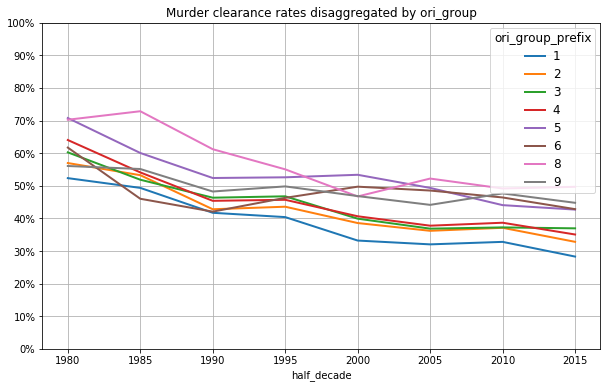

In [43]:
(
    (
        annual_counts_annotated
        .loc[lambda df: df["cleared"] > 0]
        .loc[lambda df: df["consistent_1980"] == True]
        .loc[lambda df: df["year"] >= 1980]
        .loc[lambda df: df["offense"] == "assault_gun"]
    )
    .assign(
        half_decade = lambda df: (df["year"] // 5) * 5,
        ori_group_prefix = lambda df: df["ori_group_2016"].str.slice(0, 1)
    )
    .groupby([ "half_decade", "ori_group_prefix" ])
    .apply(calculate_clearance_rate)
    .unstack()
    .pipe(
        plot_rates,
        title = "Murder clearance rates disaggregated by ori_group"
    )
)
pass

---

---

---